In [1]:
import os
import csv
import sys
import json
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_auc_score

from collections import defaultdict

%matplotlib inline

In [2]:
sys.path.append('../src')
import plot_helpers as ph
pd.set_option('display.precision', 3)

In [3]:
experiment_id = "10"
experiment = json.load(open('../analysis.json'))["experiments"][experiment_id]

In [4]:
from IPython.display import Markdown as md
md(f"""
## {experiment['name']}

### Description
{experiment['description']}

### Results
- PubMedBERT high slight performance benefits over ClinicalBERT. There is especially a less significant drop off in performance from the default train/val/test split and the TAC split.
- Consistent results between our 80/10/10 split and TAC's 45/5/50 split for PubMedBERT.
- Results are consistent between our analysis and TAC official eval script.

""")


## TAC Training/Testing Split

### Description
Use the TAC training and testing splits instead of randomly splitting.

### Results
- PubMedBERT high slight performance benefits over ClinicalBERT. There is especially a less significant drop off in performance from the default train/val/test split and the TAC split.
- Consistent results between our 80/10/10 split and TAC's 45/5/50 split for PubMedBERT.
- Results are consistent between our analysis and TAC official eval script.



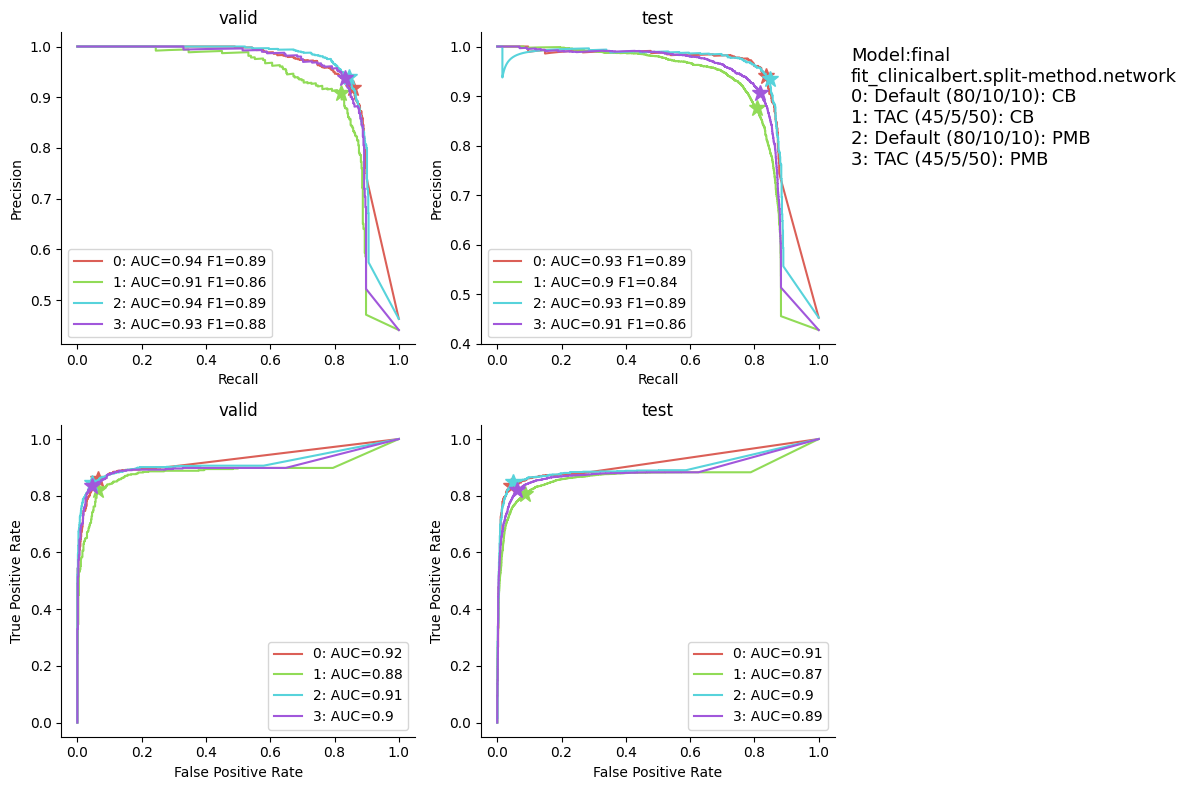

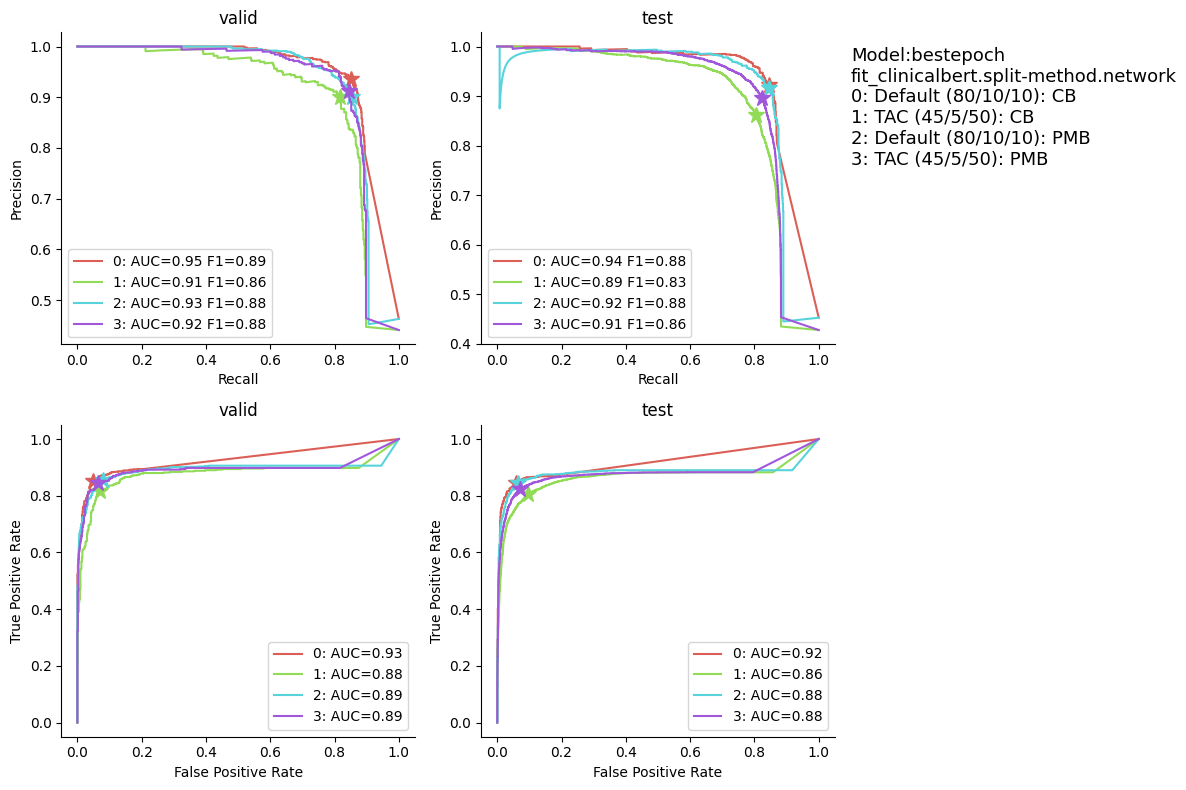

In [5]:
perfdata = defaultdict(lambda: defaultdict(list))

for modeltype in ('final', 'bestepoch'):
    resfiles = experiment[modeltype]
    colors = sns.color_palette("hls", len(resfiles))

    plt.figure(figsize=(12,8))
    plotcounter = 1


    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]

            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            perfdata[(modeltype, split)]['prdata'].append(prdata)
            
            plt.plot(prdata['recall'], prdata['precision'], color=colors[i], 
                     label=f'{i}: AUC={prdata["pr_auc"]:.2} F1={prdata["max_f1"]:.2}'
                    )
            plt.plot([prdata['max_f1_recall']], [prdata['max_f1_precision']], '*', color=colors[i], markersize=12)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        sns.despine()

    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]

            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            rocdata = ph.rocdata(split_df['label'], split_df['Pred1'], prdata['max_f1_threshold'])
            perfdata[(modeltype, split)]['rocdata'].append(rocdata)
            
            plt.plot(rocdata['fpr'], rocdata['tpr'], color=colors[i], 
                     label=f'{i}: AUC={rocdata["roc_auc"]:.2}'
                    )
            plt.plot([rocdata['max_f1_fpr']], [rocdata['max_f1_tpr']], '*', color=colors[i], markersize=12)

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        sns.despine()

    plt.subplot(2, 2, 2)
    reflegend = f'Model:{modeltype}\n{experiment["factor"]}\n' + '\n'.join([f"{i}: {s}" for i, s in enumerate(experiment['labels'])])
    plt.text(1.1, 1.0, reflegend, fontsize=13, verticalalignment='top')
    #plt.suptitle(modeltype)
    plt.tight_layout()
    
    plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}.pdf')

3.296865463256836 ./results/grouped-mean-bestepoch-bydrug-CB_8-AR-125-all_222_TAC_25_1e-06_256_32.csv
3.63829493522644 ./results/grouped-mean-bestepoch-bydrug-PMB_8-AR-125-all_222_TAC_25_1e-06_256_32.csv


,Factor,Valid Precision,Valid Recall,Valid F1,Valid AUPR,Valid AUROC,Threshold,Test Precision,Test Recall,Test F1,Test AUPR,Test AUROC
0,Default (80/10/10): CB,0.937,0.852,0.893,0.948,0.927,2.014,0.922,0.846,0.882,0.939,0.916
1,TAC (45/5/50): CB,0.901,0.818,0.857,0.906,0.878,3.297,0.863,0.806,0.833,0.894,0.865
2,Default (80/10/10): PMB,0.901,0.855,0.878,0.929,0.892,3.619,0.917,0.846,0.880,0.917,0.881
3,TAC (45/5/50): PMB,0.912,0.846,0.878,0.924,0.893,3.638,0.896,0.824,0.858,0.907,0.877


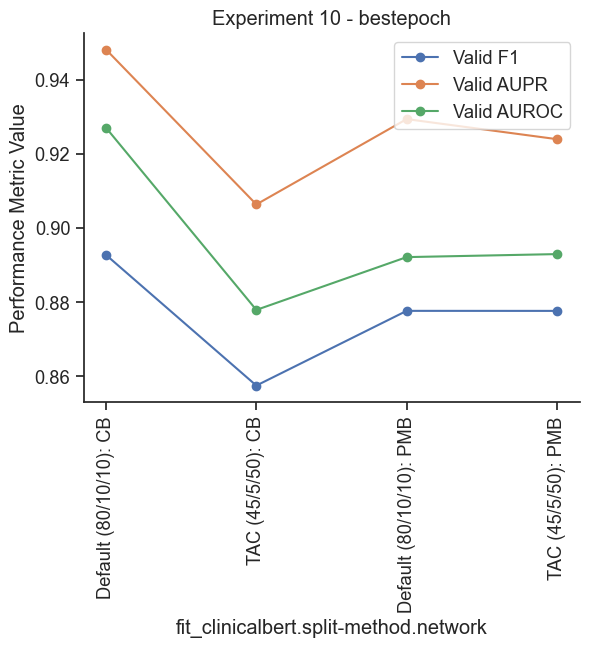

In [6]:
modeltype = 'bestepoch'
key = (modeltype, 'valid')
dfdata = {
    'Factor': experiment['labels'],
    'Valid Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Valid Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Valid F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Valid AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Valid AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
    'Threshold': [d['max_f1_threshold'] for d in perfdata[key]['prdata']]
}

valid = pd.DataFrame(dfdata)

key = (modeltype, 'test')
dfdata = {
#     'Factor': experiment['labels'],
    'Test Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Test Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Test F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Test AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Test AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

test = pd.DataFrame(dfdata)

sns.set(style='ticks', font_scale=1.2)

for col in ('Valid F1', 'Valid AUPR', 'Valid AUROC'):
    plt.plot(valid[col], 'o-', label=col)

plt.xticks(ticks = range(len(valid)), labels = valid['Factor'], rotation=90)
plt.xlabel(experiment['factor'])
plt.ylabel('Performance Metric Value')
plt.title(f"Experiment {experiment_id} - {modeltype}")
plt.legend()
sns.despine()

plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}-summary-stats.pdf')

print(valid['Threshold'][1], experiment[modeltype][1])
print(valid['Threshold'][3], experiment[modeltype][3])
pd.concat([valid, test], axis=1)

In [10]:
md(f"""
## Replication using TAC Official Eval Script

### Steps

1. Confirm gold standard files are generated by running:

```
python3 src/tac_create_gold_xml.py --section AR
```

2. Create the prediction xml files using:

```
python3 src/tac_generate_xml.py --section AR --results {experiment[modeltype][1]} --threshold {valid['Threshold'][1]}
```
```
python3 src/tac_generate_xml.py --section AR --results {experiment[modeltype][3]} --threshold {valid['Threshold'][3]}

```

3. Run official eval script:

```
python3 src/tac_official_eval_script.py -3 ./data/200_xml/AR ./data/xml_output/AR/{os.path.split(experiment[modeltype][1])[-1].split('.')[0]}
```
```
python3 src/tac_official_eval_script.py -3 ./data/200_xml/AR ./data/xml_output/AR/{os.path.split(experiment[modeltype][3])[-1].split('.')[0]}
```

### Results

| Model        | Macro-F1    |
| -----------  | ----------- |
| ClinicalBERT | 80.33       |
| PubMedBERT   | 83.41       |

""")


## Replication using TAC Official Eval Script

### Steps

1. Confirm gold standard files are generated by running:

```
python3 src/tac_create_gold_xml.py --section AR
```

2. Create the prediction xml files using:

```
python3 src/tac_generate_xml.py --section AR --results ./results/grouped-mean-final-bydrug-CB_8-AR-125-all_222_TAC_25_1e-06_256_32.csv --threshold 3.7686094641685486
```
```
python3 src/tac_generate_xml.py --section AR --results ./results/grouped-mean-final-bydrug-PMB_8-AR-125-all_222_TAC_25_1e-06_256_32.csv --threshold 4.311495780944824

```

3. Run official eval script:

```
python3 src/tac_official_eval_script.py -3 ./data/200_xml/AR ./data/xml_output/AR/grouped-mean-final-bydrug-CB_8-AR-125-all_222_TAC_25_1e-06_256_32
```
```
python3 src/tac_official_eval_script.py -3 ./data/200_xml/AR ./data/xml_output/AR/grouped-mean-final-bydrug-PMB_8-AR-125-all_222_TAC_25_1e-06_256_32
```

### Results

| Model        | Macro-F1    |
| -----------  | ----------- |
| ClinicalBERT | 80.33       |
| PubMedBERT   | 83.41       |



,Factor,Valid Precision,Valid Recall,Valid F1,Valid AUPR,Valid AUROC,Threshold,Test Precision,Test Recall,Test F1,Test AUPR,Test AUROC
0,Default (80/10/10): CB,0.918,0.857,0.887,0.945,0.924,2.925,0.941,0.835,0.885,0.934,0.914
1,TAC (45/5/50): CB,0.909,0.820,0.862,0.911,0.885,3.769,0.875,0.806,0.839,0.899,0.871
2,Default (80/10/10): PMB,0.941,0.846,0.891,0.941,0.915,3.586,0.935,0.849,0.890,0.925,0.900
3,TAC (45/5/50): PMB,0.937,0.834,0.883,0.930,0.904,4.311,0.906,0.819,0.860,0.911,0.888


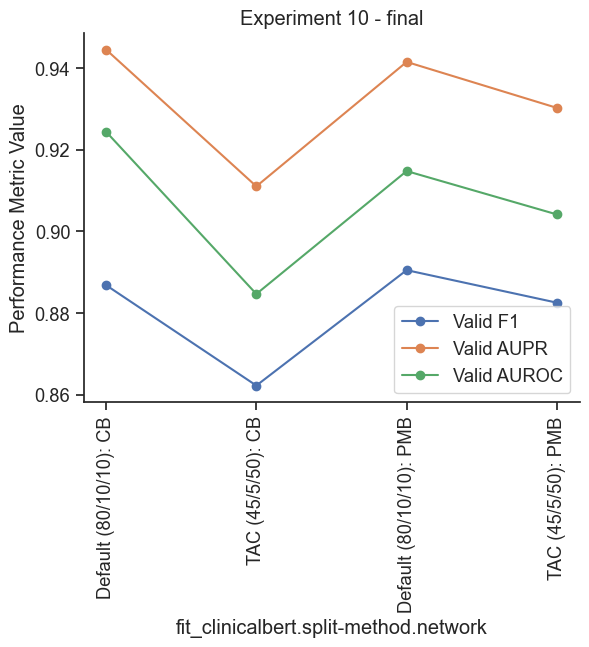

In [11]:
modeltype = 'final'
key = (modeltype, 'valid')
dfdata = {
    'Factor': experiment['labels'],
    'Valid Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Valid Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Valid F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Valid AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Valid AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
    'Threshold': [d['max_f1_threshold'] for d in perfdata[key]['prdata']]
}

valid = pd.DataFrame(dfdata)

key = (modeltype, 'test')
dfdata = {
#     'Factor': experiment['labels'],
    'Test Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Test Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Test F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Test AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Test AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

test = pd.DataFrame(dfdata)

sns.set(style='ticks', font_scale=1.2)

for col in ('Valid F1', 'Valid AUPR', 'Valid AUROC'):
    plt.plot(valid[col], 'o-', label=col)

plt.xticks(ticks = range(len(valid)), labels = valid['Factor'], rotation=90)
plt.xlabel(experiment['factor'])
plt.ylabel('Performance Metric Value')
plt.title(f"Experiment {experiment_id} - {modeltype}")
plt.legend()
sns.despine()

plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}-summary-stats.pdf')

pd.concat([valid, test], axis=1)

In [12]:
for fn in experiment['epochperf']:
    df = pd.read_csv(os.path.join('..', fn))
    print(fn, np.argmin(df['valid_loss']))

./results/epoch-results-CB_8-AR-125-all_222_24_25_1e-06_256_32.csv 11
./results/epoch-results-CB_8-AR-125-all_222_TAC_25_1e-06_256_32.csv 7
./results/epoch-results-PMB_8-AR-125-all_222_24_25_1e-06_256_32.csv 3
./results/epoch-results-PMB_8-AR-125-all_222_TAC_25_1e-06_256_32.csv 7
